<a href="https://colab.research.google.com/github/hyaochn/RUP-Net/blob/master/RUP_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Residual U-Net + Pixel De-convolution Network**



1.   Import library
2.   Mount Google Drive to load dataset. Att: /X, /Y to load correctly.


In [26]:
%tensorflow_version 2.x
import tensorflow as tf
print("tensorflow version: ",tf.__version__)

import h5py
import numpy as np
import matplotlib.pyplot as plt


import tensorflow.keras as keras
import scipy.ndimage as snd


tensorflow version:  2.1.0


In [27]:
from google.colab import drive
drive.mount('gdrive')
#!ls "gdrive/My Drive/Deep-Learning/Data"


!pip install tensorflow_io

import tensorflow_io as tfio
print("tensorflow_io version: ",tfio.__version__)

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).
tensorflow_io version:  0.12.0


In [0]:
BATCH_SIZE=1
EPOCH=5
CHANNEL_AXIS=4

#number of epoch to augment, if 2, 4*orig size new images are generated
#because one epoch including flip and rotate
AUGMENT_EPOCH=0 


root_dir="gdrive/My Drive/Deep-Learning/"
train_fn=root_dir+"Data/train.h5"
test_fn=root_dir+"Data/test.h5"

#!ls "$train_fn"

#x_train, y_train= tfio.IODataset.from_hdf5(train_fn, dataset='/X'), tfio.IODataset.from_hdf5(train_fn, dataset='/Y')
#x_test, y_test= tfio.IODataset.from_hdf5(test_fn, dataset='/X'), tfio.IODataset.from_hdf5(test_fn, dataset='/Y')

#conf=tf.io.read_file(root_dir+"Configures/train.csv")


In [0]:
#last channel axis is also number of class (1+1=2)
#image_shape=x_train.element_spec.shape
#print(image_shape)

train_f=h5py.File(train_fn,'r')
x_train, y_train=np.array(train_f['X']), np.array(train_f['Y'])

SHUFFLE_SIZE=BATCH_SIZE*np.prod(y_train.shape)

y_train=tf.one_hot(y_train, 2, CHANNEL_AXIS)
train_set=tf.data.Dataset.from_tensor_slices((x_train, y_train))


test_f=h5py.File(test_fn,'r')
x_test, y_test=np.array(test_f['X']), np.array(test_f['Y'])
y_test=tf.one_hot(y_test, 2, CHANNEL_AXIS)
#print(x_train.shape, y_train.shape)
#print(x_test.shape, y_test.shape)

Augmentation

In [0]:
#https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/#rotation-and-flipping
def plot_dataset(dataset, n_cases=8, n_slices_per_case=10):
  num_of_sets=len(dataset.element_spec)
  img_shape=dataset.element_spec[0].shape
  #[0]=slice/depth, [1]=width, [2]=height, [3]=color
  d,w,h,c=0,1,2,3
  dep,wid,hei=img_shape[d], img_shape[w], img_shape[h]
  slices=np.rint(np.linspace(0,1,n_slices_per_case)*(dep-1)).astype(np.int32)
  output = np.zeros((num_of_sets, hei * n_slices_per_case,wid * n_cases))

  i=0
  for case in dataset.take(n_cases):
    for j in range(num_of_sets):
      input=case[j].numpy()
      input=input[slices,:,:,0]
      output[j, :,i*wid:(i+1)*wid]=np.vstack(input)
    i += 1

  fig, ax = plt.subplots(1,num_of_sets, figsize=(15,15))
  for i in range(num_of_sets):
    #plt.imshow(output, extent=[1,n_cases, slices[-1], slices[0]])
    img=ax[i].imshow(output[i,:,:], cmap="gray", aspect="auto")
    xtick=np.arange(1,n_cases+1)
    ytick=slices/(slices[1]-slices[0])
    ax[i].set_xticks(xtick*wid-wid*0.5)
    ax[i].set_xticklabels(xtick)
    ax[i].set_yticks(ytick*hei+hei*0.5)
    ax[i].set_yticklabels(slices)
    #ax[i].set_title("Title")
    ax[i].set_xlabel("Case #")
    ax[i].set_ylabel("Slice #")
    fig.show(img)


In [0]:
def aug_rotate(img):
  nb=img.shape[0]
  outimg=[]
  for i in range(nb):
    outimg.append(tf.image.rot90(img[i,:,:,:], tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)))
  outimg=tf.stack(outimg)
  return outimg

def aug_flip(img):
  nb=img.shape[0]
  outimg=[]
  for i in range(nb):
    outimg.append(tf.image.flip_left_right(img[i,:,:,:]))
  outimg=tf.stack(outimg)
  return outimg

def dataset_len(dataset):
  i=0
  for e in dataset:
    i +=1
  return i
#for i in train_set.take(1):
#  ximg=i[0][45,:,:,0]
#  yimg=i[1][45,:,:,0]


if AUGMENT_EPOCH>0:
  augmentations = [aug_flip, aug_rotate]

  print("Before augmentation, train_set size = ",dataset_len(train_set))
  orig=train_set
  for i in range(AUGMENT_EPOCH):
    for f in augmentations:
      train_set=train_set.concatenate(orig.map(lambda x,y: (f(x), f(y)), num_parallel_calls=tf.data.experimental.AUTOTUNE))
  print("After augmentation, train_set size = ",dataset_len(train_set))
#for i in xxx.take(1):
#  ximg_aug=i[0][45,:,:,0]
#  yimg_aug=i[1][45,:,:,0]

#fig, ax = plt.subplots(2, 2)
#ax[0,0].imshow(ximg,cmap="gray")
#ax[0,1].imshow(ximg_aug,cmap="gray")
#ax[1,0].imshow(yimg, cmap="gray")
#ax[1,1].imshow(yimg_aug, cmap="gray")

In [32]:
train_set=train_set.batch(BATCH_SIZE).shuffle(SHUFFLE_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

print(np.amin(x_train))
print(np.amax(x_train))
print(train_set.element_spec)
print(y_train.shape)

0.0
4605.0
(TensorSpec(shape=(None, 64, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 64, 2), dtype=tf.int32, name=None))
(64, 64, 64, 64, 2)


Model: "RUP-Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input/BN (BatchNormalization (None, 64, 64, 64, 1)     4         
_________________________________________________________________
C1 (Conv3D)                  (None, 64, 64, 64, 2)     56        
Total params: 60
Trainable params: 58
Non-trainable params: 2
_________________________________________________________________


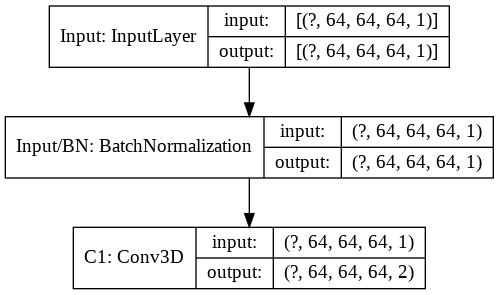

In [33]:
#  keras.layers.BatchNormalization(),
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=x_train.shape[1:], name="Input"),
  keras.layers.BatchNormalization(name="Input/BN"),
  keras.layers.Conv3D(2, kernel_size=(3,3,3), padding="same",activation=keras.activations.relu, name="C1")
],
name="RUP-Net")

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

keras.utils.plot_model(model, 'RUP-Net.png', show_shapes=True)

In [52]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)
model.fit(train_set, epochs=EPOCH, validation_data=(x_test, y_test), validation_steps=BATCH_SIZE, callbacks=[earlystop])


Train for 64 steps, validate on 17 samples
Epoch 1/5
64/64 [==============================] - 19s 293ms/step - loss: 2.4005 - accuracy: 0.9647 - val_loss: 2.3785 - val_accuracy: 0.9677
Epoch 2/5
64/64 [==============================] - 18s 278ms/step - loss: 2.3902 - accuracy: 0.9677 - val_loss: 2.3931 - val_accuracy: 0.9702
